## The effect of varying gamma in a simple corridor domain. 

#### Domain:
The corridor has 20 states [0, 1, ... , 19] and the agent starts at index 1. The agent has 3 actions [left, right, exit]. The episode terminates if the agent chooses to exit the corridor, however, the rewward it recieves varies based on the exit point. Exiting at index 0 results in a reward of +1, exiting at index 19 results in a reward of +2, all other exit points result in a reward of -10. 

#### Methodology:
All agents are training with tabular Q learning, with optimistic initialization of 2.0 and a learning rate of 1.0. We compare 2 agents, one with gamma=0.5 and another with gamma=0.99

#### Discussion:
One can see below that by varying gamma we produce different optimal behavior. The gamma=0.5 (short horizon) agent converges to seek the small reward while the gamma=0.99 (long horizon) agent goes for the larger reward at the end of the corridor. Due to the optimistic initialization, the long horizon agent needs to try to exit the corridor at each state, whereas the short horizon agent does not suffer from this problem as the small positive reward one time step away outweighs any potential distant future reward. Due to this, the short horizon agent outperforms the long horizon agent at the start of training but is surpassed once the long horizon agent has had the chance to try out all possible actions. 

In [1]:
import numpy as np

class Corridor(object):
    def __init__(self, num_states=20, max_steps=50):
        self.num_states = num_states
        self.state_shape = [num_states]
        self.nb_actions = 3
        self.state = np.zeros((num_states), dtype='float32')
        self.max_steps = max_steps
        self.start_pos = 1
        self.counter = 0
        
    def observe(self):
        return np.copy(self.state) 

    def _is_over(self, action):
        # exit or max number of steps
        return action == 2 or self.counter >= self.max_steps 

        
    def _update_state(self, action):
        # no-op
        if (action == 0 and self.pos == 0) or (action == 1 and self.pos == self.num_states - 1):  
            pass
        elif action == 0:  # move left
            self.state = np.zeros((self.num_states), dtype='float32')
            self.state[self.pos - 1] = 1
            self.pos -= 1
        elif action == 1:  # move right
            self.state = np.zeros((self.num_states), dtype='float32')
            self.state[self.pos + 1] = 1
            self.pos += 1
        elif action == 2:
            self.state = np.zeros((self.num_states), dtype='float32')
    
    def _get_reward(self, action):
        if action == 2:
            if self.pos == 0:
                reward = 1
            elif self.pos == self.num_states - 1:
                reward = 2
            else:
                reward = -10 #2 * (self.pos - self.start_pos)
        else:
            reward = 0.0
        return reward
    
    def act(self, action):
        assert action == 0 or action == 1 or action == 2
        reward = self._get_reward(action)
        self._update_state(action)
        game_over = self._is_over(action)
        self.counter += 1
        # #  
        return np.copy(self.state), reward, game_over
        
    def reset(self):
        self.state = np.zeros((self.num_states), dtype='float32')
        self.state[self.start_pos] = 1
        self.pos = self.start_pos
        self.counter = 0

In [2]:
"""
    Tabular Q agent
"""

class Agent(object):
    def __init__(self, state_shape, nb_actions, gamma, lr=1.0):
        self.state_shape = state_shape
        self.nb_actions = nb_actions
        self.gamma = gamma
        self.lr = lr
        self.table = np.ones((state_shape[0], nb_actions)) * 2.0
    
    def _predict(self, state):
        return self.table[np.argmax(state[0])]
    
    def _train(self, sarst):
        s, a, r, s2, t = sarst
        q = self.table[np.argmax(s)][a]
        target = r + (1 - t) * self.gamma * np.max(self.table[np.argmax(s2)])
        self.table[np.argmax(s)][a] += self.lr * (target - q)

    def get_action(self, state, epsilon):
        if np.random.binomial(1, epsilon):
            return np.random.randint(self.nb_actions)
        else:
            q = self._predict([state])
            return np.argmax(q)

    def learn(self, s, a, r, s2, t):
        return self._train([s, a, r, s2, t])

In [3]:
"""
    Global imports and variables
"""

%matplotlib inline

import numpy as np
import seaborn
import pickle

nb_runs_each = 10
nb_episodes = 50
gammas = [0.5, 0.99]
epsilon = 0.0

In [4]:
"""
    Runs each agent defined by a particular gamma -
    for a fixed number of episodes ("nb_episodes"). 
    Each run is repeated "nb_runs_each" times to compute some measure of variance.
"""

env = Corridor()
agents = [Agent(env.state_shape, env.nb_actions, gamma) for gamma in gammas]
all_agent_cumul_rewards = np.empty((nb_runs_each, nb_episodes, len(agents)))
all_agent_ep_rewards = np.empty((nb_runs_each, nb_episodes, len(agents)))

def do_episode(env, agent, epsilon=1.0, learn=True):
    env.reset()
    terminal = False
    reward = 0
    actions = []
    discount = 1
    gamma = 0.99
    while not terminal:
        s = env.observe()
        a = agent.get_action(s, epsilon=epsilon)
        s2, r, terminal = env.act(a)
        if learn:
            agent.learn(s, a, r, s2, terminal)
        reward += r * discount
        discount *= gamma
        actions.append(a)
    return reward, actions
    
for agent_index, agent in enumerate(agents):
    for run in range(nb_runs_each):
        cumul_rewards = 0
        for ep in range(nb_episodes):
            ep_reward, _ = do_episode(env, agent, epsilon, learn=True)
            cumul_rewards += ep_reward
            all_agent_cumul_rewards[run, ep, agent_index] = cumul_rewards
            all_agent_ep_rewards[run, ep, agent_index] = ep_reward
            
with open('cumul_rewards', 'wb') as f:
    pickle.dump(all_agent_cumul_rewards, f)
with open('ep_rewards', 'wb') as f:
    pickle.dump(all_agent_ep_rewards, f)

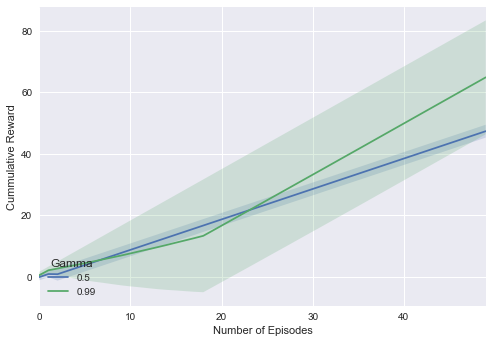

In [5]:
with open('cumul_rewards', 'rb') as f:
     all_agent_cumul_rewards = pickle.load(f)

plot = seaborn.tsplot(data=all_agent_cumul_rewards, legend=True, condition=gammas)
plot.legend(loc='lower left', title='Gamma')
plot.set_ylabel("Cummulative Reward")
plot.set_xlabel("Number of Episodes")

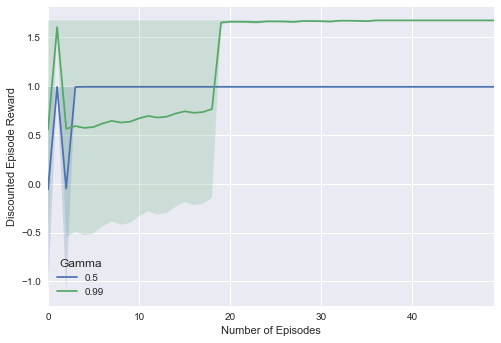

In [6]:
with open('ep_rewards', 'rb') as f:
     all_agent_ep_rewards = pickle.load(f)
        
plot = seaborn.tsplot(data=all_agent_ep_rewards, legend=True, condition=gammas)
plot.legend(loc='lower left', title='Gamma')
plot.set_ylabel("Discounted Episode Reward")
plot.set_xlabel("Number of Episodes")

In [7]:
# view learned polices
int_to_action = ['Left', 'Right', 'Exit']
for agent_index, agent in enumerate(agents):
    reward, actions = do_episode(env, agent, epsilon=0.0)
    action_words = [int_to_action[a] for a in actions]
    print("Gamma = " + str(gammas[agent_index]), "| Actions : ", action_words, "| Reward ", reward) 
    

Gamma = 0.5 | Actions :  ['Left', 'Exit'] | Reward  0.99
Gamma = 0.99 | Actions :  ['Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Exit'] | Reward  1.6690275229001748
